<a href="https://colab.research.google.com/github/Ahmed-Haitham/AWS-Udacity-Image-Classifier-Model/blob/main/AWS_%26_Udacity_Image_Classifier_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**AWS & Udacity Image Classifier Model**
**By: Ahmed Haitham Abdelmaksoud**


<img src='https://howieko.com/projects/images/Flowers.png' width=600px>

##**Project Description**:

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, we might want to include an image classifier in a smart phone app. To do this, we'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, we'll train an image classifier to recognize different species of flowers. We can imagine using something like this in a phone app that tells us the name of the flower our camera is looking at. In practice we'd train this classifier, then export it for use in our application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, we can see a few examples below. 

## **Developing an AI application**





**The project is broken down into multiple steps:**

* Load and preprocess the image dataset
* Train the image classifier on our dataset
* Use the trained classifier to predict image content

We'll go through each part which we'll implement in Python.

When we've completed this project, we'll have an application that can be trained on any set of labeled images. Here our network will be learning about flowers and end up as a command line application. But, what we do with our new skills depends on our imagination and effort in building a dataset. For example, imagine an app where we take a picture of a car, it tells us what the make and model is, then looks up information about it. Go build our own dataset and make something new.

First up is importing the packages we'll need. It's good practice to keep all the imports at the beginning of our code. As we work through this notebook and find we need to import a package.

In [ ]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import transforms, models, datasets


## **Load the data**

Here we'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise we can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, we'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. we'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this we don't want any scaling or rotation transformations, but we'll need to resize then crop the images to the appropriate size.

The pre-trained networks we'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets we'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [ ]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [ ]:
# Define our transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])



# Load the datasets with ImageFolder
train_datasets = datasets.ImageFolder(train_dir, transform = train_transforms)
valid_datasets = datasets.ImageFolder(valid_dir, transform = valid_transforms)
test_datasets = datasets.ImageFolder(test_dir, transform = test_transforms)

# Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_datasets, batch_size = 64, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_datasets, batch_size = 64)
testloader = torch.utils.data.DataLoader(test_datasets, batch_size = 64)

## **Label mapping**

we'll also need to load in a mapping from category label to category name. we can find this in the file `cat_to_name.json`. It's a JSON object which we can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give us a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [ ]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

## **Building and training the classifier**

Now that the data is ready, it's time to build and train the classifier. As usual, we should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to us. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance. Things we'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If we need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

When training make sure we're updating only the weights of the feed-forward network. we should be able to get the validation accuracy above 70% if we build everything right. We'll make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. We'll save those hyperparameters to use as default values in the next part of the project.

One last important tip if we're using the workspace to run our code: To avoid having our workspace disconnect during the long-running tasks in this notebook, keeping our Session Active. we'll want to include code from the workspace_utils.py module.

In [ ]:
# Define the Model

# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# We can load in a model such as VGG. Let's print out the model architecture so we can see what's going on.
model = models.vgg16(pretrained = True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
from collections import OrderedDict
model.classifier = nn.Sequential(OrderedDict([
                          ("fc1", nn.Linear(25088, 4096)),
                          ("relu1", nn.ReLU()),
                          ("fc2", nn.Linear(4096, 1024)),
                          ("relu2", nn.ReLU()),
                          ("fc3", nn.Linear(1024, 512)),
                          ("relu3", nn.ReLU()),
                          ("dropout", nn.Dropout(p = 0.2)),
                          ("fc4", nn.Linear(512, 102)),
                          ("output", nn.LogSoftmax(dim = 1))]))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.003)

model.to(device);

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:04<00:00, 110746882.53it/s]


In [ ]:
from workspace_utils import active_session

with active_session():
    # Let's use the model
    epochs = 10
    steps = 0
    train_loss = 0
    print_every = 5

    for epoch in range(epochs):
        for inputs, labels in trainloader:
            steps += 1
            # Move input and label tensors to the default device
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if steps % print_every == 0:
                # start our validation
                valid_loss = 0
                accuracy = 0

                model.eval()

                with torch.no_grad():
                    for inputs, labels in validloader:
                        inputs, labels = inputs.to(device), labels.to(device)

                        logps = model.forward(inputs)
                        batch_loss = criterion(logps, labels)

                        valid_loss += batch_loss.item()

                        # Calculate accuracy
                        ps = torch.exp(logps)
                        top_p, top_class = ps.topk(1, dim = 1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                print(f"Epoch {epoch+1}/{epochs}.. "
                      f"Train loss: {train_loss/print_every:.3f}.. "
                      f"Valid loss: {valid_loss/len(validloader):.3f}.. "
                      f"Valid accuracy: {accuracy/len(validloader):.3f}")

                train_loss = 0
                model.train()

Epoch 1/10.. Train loss: 10.708.. Valid loss: 4.584.. Valid accuracy: 0.022
Epoch 1/10.. Train loss: 4.575.. Valid loss: 4.470.. Valid accuracy: 0.041
Epoch 1/10.. Train loss: 4.578.. Valid loss: 4.388.. Valid accuracy: 0.079
Epoch 1/10.. Train loss: 4.342.. Valid loss: 4.266.. Valid accuracy: 0.079
Epoch 1/10.. Train loss: 4.192.. Valid loss: 4.022.. Valid accuracy: 0.101
Epoch 1/10.. Train loss: 4.141.. Valid loss: 3.803.. Valid accuracy: 0.131
Epoch 1/10.. Train loss: 3.905.. Valid loss: 3.682.. Valid accuracy: 0.144
Epoch 1/10.. Train loss: 3.555.. Valid loss: 3.335.. Valid accuracy: 0.223
Epoch 1/10.. Train loss: 3.476.. Valid loss: 3.070.. Valid accuracy: 0.269
Epoch 1/10.. Train loss: 3.151.. Valid loss: 3.003.. Valid accuracy: 0.251
Epoch 1/10.. Train loss: 3.021.. Valid loss: 2.787.. Valid accuracy: 0.273
Epoch 1/10.. Train loss: 3.210.. Valid loss: 2.689.. Valid accuracy: 0.305
Epoch 1/10.. Train loss: 2.988.. Valid loss: 2.677.. Valid accuracy: 0.303
Epoch 1/10.. Train loss:

## **Testing our network**

It's good practice to test our trained network on test data, images the network has never seen either in training or validation. This will give us a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way we did validation. we should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [ ]:
from workspace_utils import active_session
with active_session():
    # TODO: Do validation on the test set
    # start our testing
    test_loss = 0
    accuracy = 0

    model.eval()

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            logps = model.forward(inputs)
            t_batch_loss = criterion(logps, labels)

            test_loss += t_batch_loss.item()

            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim = 1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    print(f"Test loss: {test_loss/len(testloader):.3f}.. "
          f"Test accuracy: {accuracy/len(testloader):.3f}")


    model.train()

Test loss: 0.979.. Test accuracy: 0.758


## **Save the checkpoint**

Now that your network is trained, save the model so we can load it later for making predictions. we probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. We can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that we'll want to completely rebuild the model later so we can use it for inference. Make sure to include any information we need in the checkpoint. If we want to load the model and keep training, we'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. we'll likely want to use this trained model in the next part of the project, so best to save it now.

In [ ]:
# Save the checkpoint 
checkpoint = {'arch' : 'vgg16',
              'input_size': 25088,
              'output_size': 102,
              'hidden_layers': [model.classifier[i].out_features for i in [0,2,4]],
              'classifier': model.classifier,
              'state_dict': model.state_dict(),
              'class_to_idx': train_datasets.class_to_idx,
              'epochs': 10,
              'dropout': 0.2,
              'optimizer_state': optimizer.state_dict}

torch.save(checkpoint, 'checkpoint.pth')

## **Loading the checkpoint**

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way we can come back to this project and keep working on it without having to retrain the network.

In [ ]:
# Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.vgg16(pretrained = True)
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    
    #turning off tuning of the model
    for param in model.parameters():
        param.requires_grad = False
    
    return model

In [ ]:
loaded_model = load_checkpoint('checkpoint.pth')
print(loaded_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

## **Inference for classification**

Now we'll write a function to use a trained network for inference. That is, we'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First we'll need to handle processing the input image such that it can be used in our network. 



## **Image Preprocessing**

We'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then we'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. We'll need to convert the values. It's easiest with a Numpy array, which we can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. We'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. We can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [ ]:
# Process a PIL image for use in a PyTorch model
from PIL import Image

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    with Image.open(image) as img:
        # Get original image dimensions
        width, height = img.size
        
        #Find the shortest side and crop it to 256
        if width < height:
            size=[256, 256**600]
        else: 
            size=[256**600, 256]
            
        img.thumbnail(size)
        
        center = width/4, height/4
        left = center[0]-(244/2)
        top = center[1]-(244/2)
        right = center[0]+(244/2)
        bottom = center[1]+(244/2)
        crop = img.crop((left, top, right, bottom))
        
        np_image = np.array(crop)/255
        
        # Normalizing each color channel
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = (np_image - mean) / std
        
        image = image.transpose((2, 0, 1))
        
    return image

In [ ]:
img = process_image('flowers/test/70/image_05331.jpg')
img

array([[[-1.46716328, -1.48428804, -1.5356623 , ..., -0.85067215,
         -0.98767018, -1.19316722],
        [-1.5356623 , -1.48428804, -1.34729001, ..., -0.91917116,
         -0.98767018, -1.24454148],
        [-1.45003853, -1.3130405 , -1.12466821, ..., -0.93629592,
         -0.97054542, -1.24454148],
        ..., 
        [-0.83354739, -0.78217313, -0.81642264, ..., -0.93629592,
         -0.83354739, -0.91917116],
        [-0.74792362, -0.78217313, -0.83354739, ..., -0.88492165,
         -0.85067215, -0.85067215],
        [-0.73079887, -0.74792362, -0.8677969 , ..., -0.95342067,
         -0.8677969 , -0.85067215]],

       [[-1.5105042 , -1.54551821, -1.59803922, ..., -0.267507  ,
         -0.51260504, -0.79271709],
        [-1.56302521, -1.5105042 , -1.37044818, ..., -0.33753501,
         -0.51260504, -0.8452381 ],
        [-1.4754902 , -1.33543417, -1.14285714, ..., -0.39005602,
         -0.51260504, -0.8452381 ],
        ..., 
        [-0.12745098, -0.07492997, -0.09243697, ...,

To check our work, the function below converts a PyTorch tensor and displays it in the notebook. If our `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [ ]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

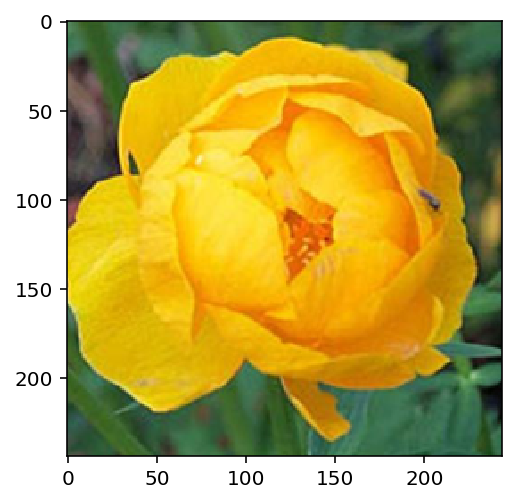

In [ ]:
imshow(process_image("flowers/test/16/image_06657.jpg"))

## **Class Prediction**

Once we can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. We'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. We need to convert from these indices to the actual class labels using `class_to_idx` which hopefully we added to the model or from an `ImageFolder` we used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so we get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [ ]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    img = process_image(image_path)
    img = torch.from_numpy(np.array([img])).float()
    
    with torch.no_grad():
        img = img.to(device)
        logps = model.forward(img)
        probability = torch.exp(logps)
        top_p, top_class = probability.topk(topk, dim = 1)
        
    # Detatch all of the details
    top_p = np.array(top_p.detach())[0] 
    top_class = np.array(top_class.detach())[0]
    
    # Convert to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_class = [idx_to_class[lab] for lab in top_class]
        
    return top_p, top_class

In [ ]:
x = predict('flowers/test/17/image_03872.jpg', loaded_model)

## **Sanity Checking**

Now that we can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='https://katba-caroline.com/wp-content/uploads/2018/11/Screenshot-75.png' width=500px>

We can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

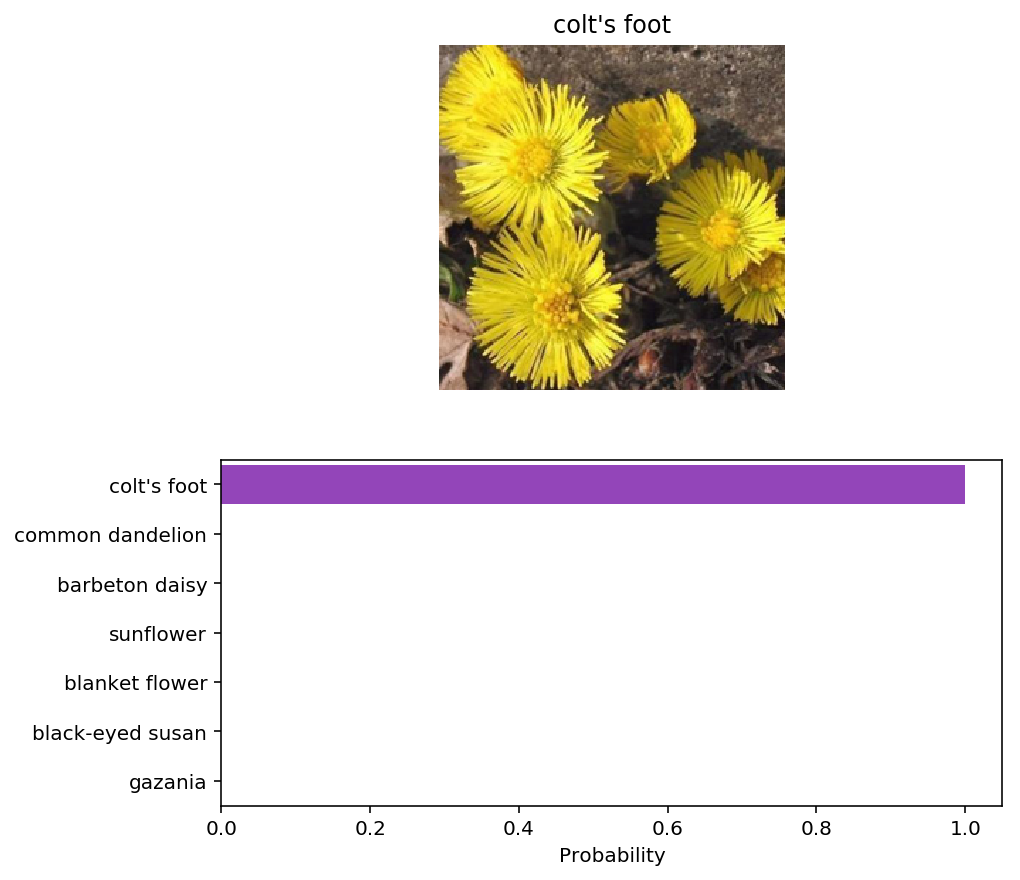

In [ ]:
# Display an image along with the top 5 classes
# Define model and image_path
model = loaded_model
image_path = "flowers/test/12/image_04077.jpg"

# Set up plot
plt.figure(figsize = (7,7))
ax1 = plt.subplot(2,1,1)

# Set up title
flower_no = image_path.split("/")[2]
img_title = cat_to_name[flower_no]
ax1.set_title(img_title)

# Plot flower
img = process_image(image_path)
ax1.axis('off')
imshow(img, ax = ax1, title = img_title)

# Set up probabilities and classes
probabilities, classes = predict(image_path, model, 7)

#preparing class_names using mapping with cat_to_name
class_names = [cat_to_name[c] for c in classes]

# Plot bar chart
ax2 = plt.subplot(2,1,2)
ax2.set_yticklabels(classes)
ax2.set_xlabel('Probability')
sns.barplot(probabilities, class_names, color = "darkorchid")
plt.show()